<a href="https://colab.research.google.com/github/SophieMargolis/Advanced_ML_DL_Course_Assignment_2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignment 2 - NLP: Seinfeld or Friends?**<br>
## By: Raz Graider, Sophie Margolis, Ran Asanta and Dana Braynin

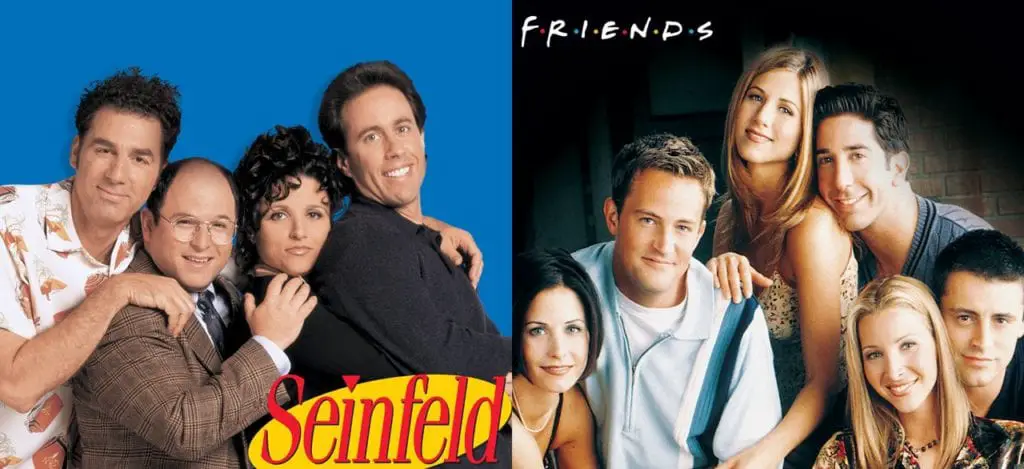

##**Introduction**

In this project, we were given a dataset containing the scripts of all Seinfeld and Friends episodes.<br>
We were asked to create a deep learning model that could identify whether a line was taken from a Seinfeld episode or from a Friends episode.<br>
This project is a Natural Language Processing (NLP) task. We were given 70,405 observations. We analyzed the given data, processed it and classified the samples in the test data.

##**Import libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import time

import os
import pandas as pd
import numpy as np

# plot libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# NLP model
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding, MaxPooling1D, LSTM
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l1

# exploring the results section
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
import random
import re
from collections import Counter

##**Loading the data**

In [ ]:
def load_files():
  '''
  output: train (the train data), test (the test data)
  '''
  # Load train data
  train = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/train.csv')

  # Load test data
  test = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/test.csv')

  return train, test

In [ ]:
df, test = load_files()

##**Exploring the data**

### Glimpse to the data

Let's have a look at the data:

In [ ]:
df.head()

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13


### Statistics

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70405 entries, 0 to 70404
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Dialogue         70405 non-null  object
 1   Character        70405 non-null  object
 2   Episode          70405 non-null  object
 3   Show             70405 non-null  object
 4   Dialogue_length  70405 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


Our dataset has 5 features (including the label) and contains 70405 samples. We will utilize only the `Dialogue` and `Show` columns for model training. There are **no** null values at all, given that all features have 70405 non-null entries. The data types observed include objects and int.<br>

Let's see the minimum, maximum, and average length of dialogues:


In [ ]:
df.describe()

,Dialogue_length
count,70405.000000
mean,11.002131
std,12.125423
min,1.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,363.000000


Let's examine the number of unique values in each column. Since we expect two labels, we'll confirm this in the table below. Additionally, we'll assess the number of characters in each column and identify if we have any duplicate dialogues.

In [ ]:
df.nunique()

Dialogue           62770
Character             10
Episode              398
Show                   2
Dialogue_length      163
dtype: int64

We will consider how to handle the duplicate dialogues depending on our model's performance with or without them.

### Label count

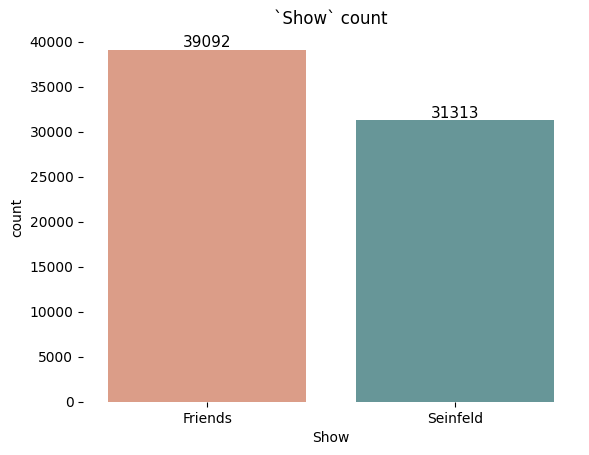

In [ ]:
# Create the countplot
ax = sns.countplot(x="Show", data=df, palette=["darksalmon", "cadetblue"])

#remove the frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add counts above each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('`Show` count', fontsize=12)
plt.show()

Our data is a little bit unbalanced.As we can see we have more samples from the Friends show than Seinfeld.

### Which character appears most in the data?

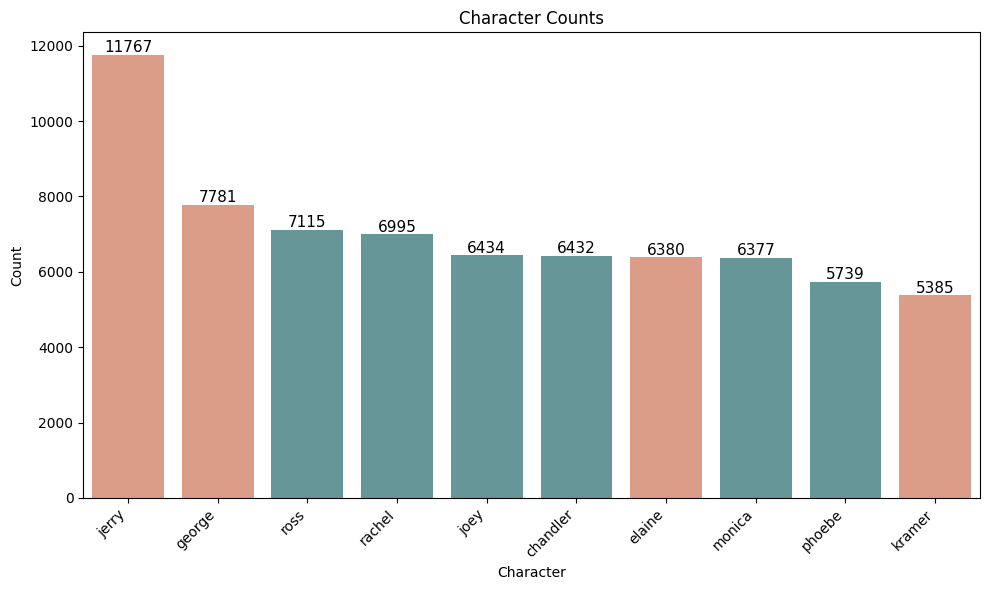

In [ ]:
# Count occurrences of each character in the 'Character' column of df
counts = df['Character'].value_counts()

# Create a new figure for the plot
plt.figure(figsize=(10, 6))

# Create a bar plot with x-values as unique characters and y-values as their counts
ax = sns.barplot(x=counts.index, y=counts.values, palette={'phoebe': 'cadetblue', 'chandler': 'cadetblue', 'rachel': 'cadetblue',
                                                       'monica': 'cadetblue', 'ross': 'cadetblue', 'joey': 'cadetblue',
                                                       'george': 'darksalmon', 'kramer': 'darksalmon', 'jerry': 'darksalmon',
                                                       'elaine': 'darksalmon'})

# Add counts above each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')

# Set label for x-axis, for y-axis and for the plot
plt.xlabel('Character')
plt.ylabel('Count')
plt.title('Character Counts')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


This makes sense. 'Seinfeld' primarily revolves around the character Jerry Seinfeld. While other characters also have dominant roles, Jerry's character is often the driving force behind the show's humor and storylines. In contrast, in 'Friends', all six main friends members are considered main characters as they play significant central roles, and the show's narrative revolves around their friendships and individual storylines.

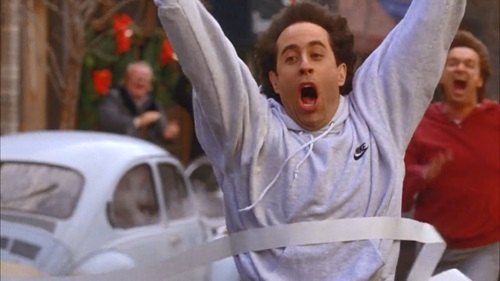

### Most common words

In [ ]:
def plot_top_words(df, show, color):
    '''
    input: df (the data frame),
          show (Friends or Seinfeld),
          color (the color to use in the plot)
    output: plot
    '''
    # Tokenize words and count frequency for the specified label
    word_freq = Counter()

    for text, label in zip(df['Dialogue'], df['Show']):
        if label == show:
            # Convert text to lowercase and split into words
            words = text.lower().split()
            # Filter out non-alphanumeric characters
            words = [word for word in words if word.isalnum()]
            # Update word frequency counter
            word_freq.update(words)

    # Convert word frequency counter to a DataFrame
    word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
    word_freq_df.index.name = 'Word'
    word_freq_df.reset_index(inplace=True)

    # Sort the DataFrame by frequency in descending order
    word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

    # Create a bar plot showing the top 10 most common words for the specified show
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x='Word', y='Frequency', data=word_freq_df.head(10), color=color)

    # Set label for x-axis, for y-axis and for the title
    plt.title(f'Top 10 Most Common Words ({show.capitalize()})')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.xticks(rotation=45)
    sns.despine()

    # Add count labels to each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

    # Display the plot
    plt.show()

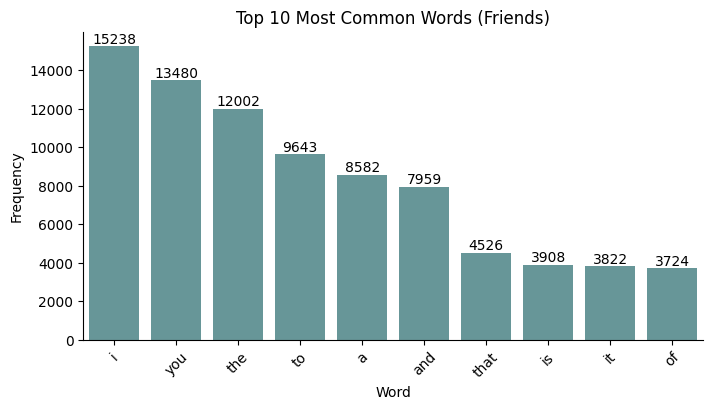

In [ ]:
plot_top_words(df, 'Friends', 'cadetblue')

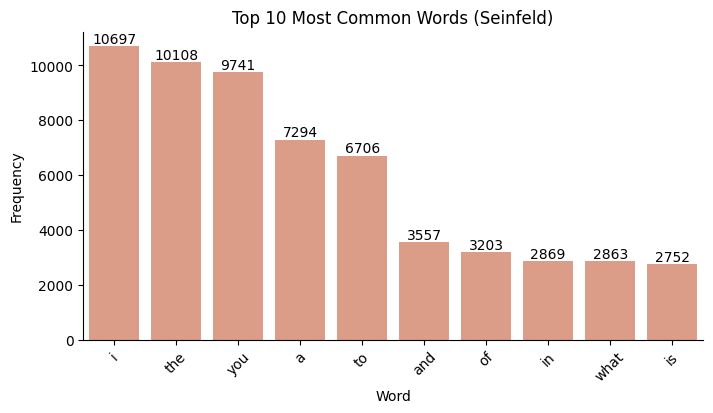

In [ ]:
plot_top_words(df, 'Seinfeld', 'darksalmon')

In the plots above, we observe that the top 10 most common words for each label consist mostly of stop words. In the preprocessing stage, we will remove these stop words, after which we will reevaluate the top 10 most common words to see how they change.

### Word count

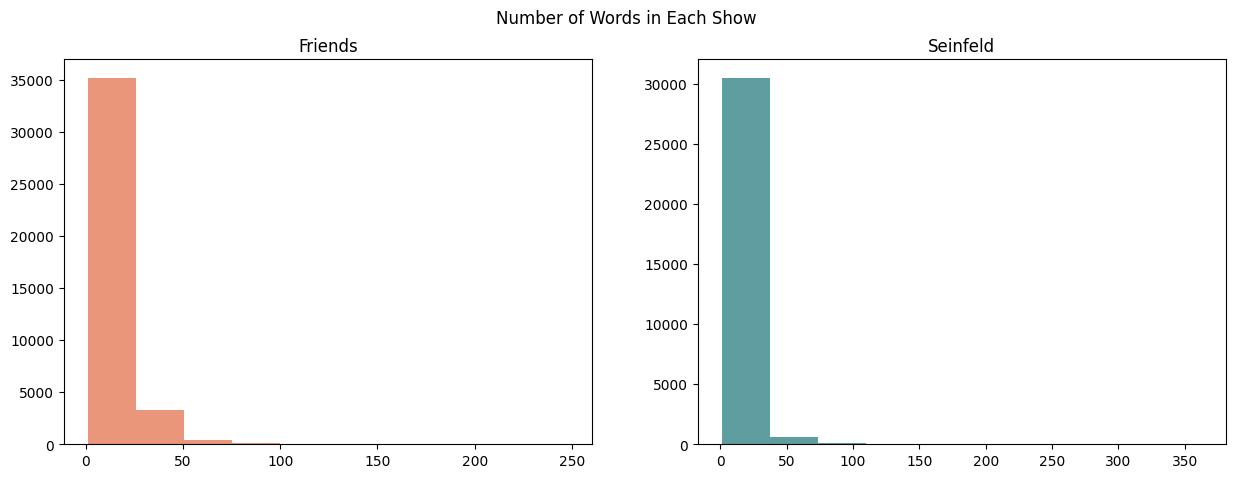

In [ ]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Calculate number of words for each dialogue in Friends
num_words_friends = df[df['Show'] == 'Friends']['Dialogue'].str.split().map(lambda x: len(x))
# Create a histogram of the number of words for 'Friends' show
ax1.hist(num_words_friends, color='darksalmon')
# Set the title of the first subplot
ax1.set_title('Friends')

# Calculate number of words for each dialogue in Seinfeld
num_words_seinfeld = df[df['Show'] == 'Seinfeld']['Dialogue'].str.split().map(lambda x: len(x))
# Create a histogram of the number of words for 'Seinfeld' show
ax2.hist(num_words_seinfeld, color='cadetblue')
# Set the title of the second subplot
ax2.set_title('Seinfeld')

# Set common title for the entire figure
fig.suptitle('Number of Words in Each Show')

# Display the plot
plt.show()

We examined the length of dialogues for each show and observed that the majority of dialogues **contain between 1 and 75 words**. However, there are some dialogues with more than 75 words, which appear as nearly unseen tails in each of the plots.<br>
Additionally, we noted from the `describe()` table that the maximum value in the `dialogue length` column of our dataset was 368, and now we found that it's a dialogue from 'Seinfeld'.

### n-grams count

In [ ]:
def get_top_ngrams(corpus, n, num_of_ngrams):
    '''
    input: corpus (the Data Frame with only the 'Dialogue' column),
           n (number of words in an expression)
           num_of_ngrams (number of top n expressions to represent)
    output: words_freq[:num_of_ngrams] (top num_of_ngrams ngrams)
    '''
    # Fit CountVectorizer to the corpus with specified ngram range
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)

    # Transform the corpus into a bag of words representation
    bag_of_words = vec.transform(corpus)

    # Sum the word occurrences across the corpus
    sum_words = bag_of_words.sum(axis=0)

    # Create a list of tuples containing the ngram and its frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort the list of tuples by frequency in descending order
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:num_of_ngrams]

In [ ]:
def plot_top_ngrams(corpus, n, num_of_ngrams):
    '''
    input: corpus (the Data Frame with only the 'Dialogue' column),
           n (number of words in an expression)
           num_of_ngrams (number of top n expressions to represent)
    output: plot
    '''
    # Create a figure for the plot
    plt.figure(figsize=(16, 5))

    # Get the top ngrams using the get_top_ngrams function
    top_ngrams = get_top_ngrams(corpus, n, num_of_ngrams)

    # Unzip the top_ngrams tuple into separate lists for x and y values
    x, y = zip(*top_ngrams)

    # Create a bar plot
    ax = sns.barplot(x=x, y=y, color='silver')
    plt.xticks(rotation=45)

    # Set label for x-axis, for y-axis and for the title
    plt.xlabel('Ngram')
    plt.ylabel('Frequency')
    plt.title(f'Top {num_of_ngrams} {n}-grams')

    # Add count labels to each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='bottom')

    plt.show()

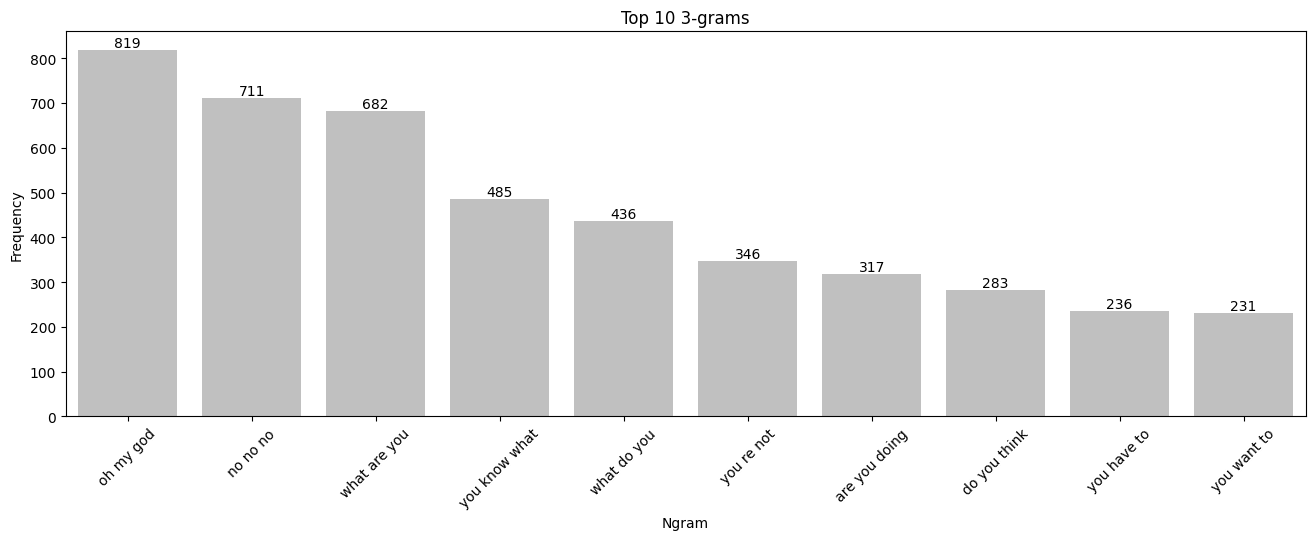

In [ ]:
plot_top_ngrams(df['Dialogue'], 3, 10)

We delved into the dialogues to identify the most common 3-grams, which are sequences of three words. Although we also examined bigrams (2-grams) and 4-grams, the analysis of 3-grams was the most interesting.<br>
* The most common sequence we found is 'oh my god,' which aligns with expectations for typical American TV shows.
* Interestingly, one of Joey's iconic catchphrases is "How you doin'?".<br> In our analysis we noticed the sequence 'are you doing,' which might refer to the same thing.

##**Preprocessing**

### Dropping duplicated samples

In natural language processing (NLP) tasks, it's common to encounter duplicate entries in the dataset.<br>
To ensure the integrity and effectiveness of our NLP analysis, we implement a function that is designed to remove duplicate entries from our dataset, thus ensuring that our NLP analysis is based on a clean and accurate dataset, free from redundant information.


In [ ]:
def drop_duplicates(data):
    '''
    input: data (the df)
    output: dropped_data (the df after dropping duplicated rows)
    '''
    # Drop duplicate rows from the input DataFrame
    dropped_data = data.drop_duplicates()

    return dropped_data

In [ ]:
df_after_dropping_duplicate = drop_duplicates(df)

Now that we dropped the duplicates entries, let's check the new shape of our dataset:

In [ ]:
df_after_dropping_duplicate.shape

(69712, 5)

If we go back to the "exploring the data" part of this assignment, we will see that the shape of the data set was `(70405, 5)`. This means that we had $70405-69712=693$ entries that were duplicated.

We will take one example through which we will make sure that a copy of the deleted entries still remains in the new data.<br>
To do so, let's see what indices were dropped from the original dataset:

In [ ]:
# Find the indices of the original DataFrame
original_indices = df.index

# Find the indices of the deduplicated DataFrame
deduplicated_indices = df_after_dropping_duplicate.index

# Find the indices of rows that were dropped
dropped_indices = original_indices.difference(deduplicated_indices)

# Check if any of the dropped rows still exist in the deduplicated DataFrame
if not dropped_indices.empty:
    print("Indices of rows that were dropped but still exist in df_after_dropping_duplicate:")
    print(dropped_indices)
else:
    print("No dropped rows found in df_after_dropping_duplicate.")

Indices of rows that were dropped but still exist in df_after_dropping_duplicate:
Int64Index([  547,  1112,  2127,  2962,  5529,  5534,  5647,  6567,  7339,
             7388,
            ...
            69985, 70061, 70067, 70069, 70177, 70178, 70181, 70241, 70261,
            70372],
           dtype='int64', length=693)


This is one example of a duplicated row:

In [ ]:
df.loc[547]

Dialogue                                                     Oh yes!
Character                                                   chandler
Episode            Season-07 Episode-11-The One With All The Chee...
Show                                                         Friends
Dialogue_length                                                    2
Name: 547, dtype: object

Let's see were was the duplication of the row above in the original data:

In [ ]:
df[df.eq(df.loc[547]).all(axis=1)].index[0]

294

In [ ]:
df.loc[294]

Dialogue                                                     Oh yes!
Character                                                   chandler
Episode            Season-07 Episode-11-The One With All The Chee...
Show                                                         Friends
Dialogue_length                                                    2
Name: 294, dtype: object

We will make sure that the same row still exists in the new dataset:

In [ ]:
df_after_dropping_duplicate[df.eq(df.loc[547]).all(axis=1)].index[0]

294

In [ ]:
df_after_dropping_duplicate.loc[294]

Dialogue                                                     Oh yes!
Character                                                   chandler
Episode            Season-07 Episode-11-The One With All The Chee...
Show                                                         Friends
Dialogue_length                                                    2
Name: 294, dtype: object

Now that we have checked that this process was done correctly, we will update the data to be the new data after dropping duplicates:

In [ ]:
df = df_after_dropping_duplicate

In [ ]:
df.shape

(69712, 5)

### Removing special characters

Special characters such as punctuation marks, symbols, and other non-alphanumeric characters can introduce noise into the dataset and interfere with NLP tasks. Therefore, in this part we removed the special characters.<br><br>

After running the deep learning model we discovered that removing the special characters lowered our score on the test. Therefore, **we decided not to use this part in our assignment** and it will not be part of the test pipeline.


In [ ]:
'''
# Removing the square brackets
def clean_text(text):
    return re.sub('[^a-zA-Z0-9\s]', '', text)
'''

"\n# Removing the square brackets\ndef clean_text(text):\n    return re.sub('[^a-zA-Z0-9\\s]', '', text)\n"

In [ ]:
# Apply function on Dialogue column
#df['Dialogue'] = df['Dialogue'].apply(clean_text)

In [ ]:
#df.iloc[333, 0]

###Removing stop words

Stop words are commonly occurring words in a language that are considered to have little or no semantic meaning in the context of natural language processing (NLP) tasks. These words often occur frequently in text data but do not contribute significantly to the overall meaning or understanding of the text. <br>
We include a step to remove stop words from the text data. By doing so, we aim to reduce noise in the dataset and improve the efficiency and accuracy the text classification.

We'll be using a Python package called Natural Language Toolkit (NLTK) to transform the textual data to a data science problem:

In [ ]:
# Download the NLTK stopwords corpus for English
nltk.download('stopwords')

# Get the list of English stopwords from the NLTK corpus
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Before applying this step, let's take a look at a sentence:

In [ ]:
df.iloc[333, 0]

' Oh, I know, I know, the odds are against us, but somebody has to win, and it could be us! And then how you gonna feel? You know, we\'re gonna be all like "oh everybody, let\'s take our helicopters up to the cape" and you\'re gonna be all like "oh, I can\'t guys, I\'ll meet you guys up there, I gotta gas up the Hyundai"'

In [ ]:
def remove_stopwords(text, is_lower_case=False):
    '''
    input: text (input text to remove stopwords from),
           is_lower_case (boolean indicating whether to convert text to
                          lowercase before removing stopwords, default is False)
    output: filtered_text (text without the stop words)
    '''
    # Tokenize the input text using the provided tokenizer
    tokens = tokenizer.tokenize(text)

    # Remove leading and trailing whitespace from tokens
    tokens = [token.strip() for token in tokens]

    # Filter out stopwords from tokens
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]

    # Join the filtered tokens back into a string
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [ ]:
# Initialize the ToktokTokenizer for tokenization
tokenizer = ToktokTokenizer()

# Removing the stopwords
tqdm.pandas()

# Apply function on Dialogue column
df['Dialogue'] = df['Dialogue'].progress_apply(remove_stopwords)

  0%|          | 0/69712 [00:00<?, ?it/s]

After removing stop words, we will look at the sentence we looked at from earlier and it appears that the following words have dropped: `I`, `are`, `but` and more.

In [ ]:
df.iloc[333, 0]

'Oh , know , know , odds us , somebody win , could us ! gonna feel ? know , \' gonna like " oh everybody , let \' take helicopters cape " \' gonna like " oh , \' guys , \' meet guys , gotta gas Hyundai "'

###Lemmatization

Lemmatization is a fundamental step in natural language processing (NLP) that involves reducing words to their base or canonical form, known as a lemma. The lemma represents the dictionary form or the canonical form of a word, which helps to normalize variations of the same word and improve the accuracy of text analysis.<br><br>
We decided to use lemmatization and not stemming because unlike stemming, which involves removing prefixes or suffixes from words to obtain their root forms and basically chops off the endings of words, lemmatization considers the word's meaning and grammer rules.<br>
Let's consider the word `stopped` as an example: Stemming will reduce it to `stopp` and lemmatization will reduce it to `stop`.

In [ ]:
def lemmatize_text(text):
    '''
    input: text (the input data frame)
    output: lemmatized_text (text after lemmatization)
    '''
    # Initialize WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Lemmatize each word
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the lemmatized tokens back into a string
    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text

In [ ]:
# Download the NLTK punkt and wordnet resources
nltk.download('punkt')
nltk.download('wordnet')

# Apply the lemmatize_text function to the 'Dialogue' column
df['Dialogue'] = df['Dialogue'].progress_apply(lemmatize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


  0%|          | 0/69712 [00:00<?, ?it/s]

By looking at this sentence, we can see for example that the word `guys` was changed to `guy`:

In [ ]:
df.iloc[333,0]

"Oh , know , know , odds u , somebody win , could u ! gon na feel ? know , ' gon na like `` oh everybody , let ' take helicopter cape `` ' gon na like `` oh , ' guy , ' meet guy , got ta gas Hyundai ``"

###Train validation split

We will split the data so that X will be the sentences (`Dialogue`) and Y, the label, will be the classification for series type (`Show`).

In [ ]:
# Assign the 'Dialogue' column from df to be X data
X = df['Dialogue']

# Assign the 'Show' column from df to be Y (label) data
Y = df['Show']

Splitting our dataset into training and validation sets helps us assess how well our model generalizes to new, unseen data.<br>
In our specific case, we split our dataset into a training set and a validation set using a 80-20 split, where 80% of the data is allocated to the training set and 20% to the validation set.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Let's verify the results:

In [ ]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (55769,)
y_train shape: (55769,)
x_val shape: (13943,)
y_val shape: (13943,)


We can also check that the distribution of our labels between train and validation is not skewed toward one class:

In [ ]:
train_label_count = y_train.value_counts()
val_label_count = y_val.value_counts()

print('Train Friends to Seinfeld ratio:', train_label_count['Friends'] / train_label_count['Seinfeld'])
print('Validation Friends to Seinfeld ratio:', val_label_count['Friends'] / val_label_count['Seinfeld'])

Train Friends to Seinfeld ratio: 1.2573059175908685
Validation Friends to Seinfeld ratio: 1.2173982188295165


In the "exploring the data" part, we saw that the ration between Friends label to Seinfeld label was $\frac{39,092}{31,313} = 1.2484$.<br>
This ratio is similarly maintained after the split to train and validation.

###Bag of words

In natural language processing (NLP), the Bag of Words (BoW) approach is a common technique used to represent text data numerically. The BoW approach treats each document as a collection of words and represents the text by counting the frequency of each word in the document.<br><br>
In the logistic regression part of our analysis, we will use the Bag of Words representation.

In [ ]:
# Initialize CountVectorizer
cv = CountVectorizer(analyzer='word')

# Fit and transform the training data x_train using CountVectorizer
x_train_cv = cv.fit_transform(x_train)

# Transform the validation data x_val using the fitted CountVectorizer
x_val_cv = cv.transform(x_val)

print('x_train_cv:', x_train_cv.shape)
print('x_val_cv:', x_val_cv.shape)

x_train_cv: (55769, 16663)
x_val_cv: (13943, 16663)


###TF-IDF

TF-IDF is a numerical representation technique commonly used in natural language processing (NLP) to evaluate the importance of a word in a document relative to a collection of documents. Words with high TF-IDF scores are considered important to the document, as they are frequent within the document but rare across the entire document collection.<br><br>

This is a different approach than BoW. While BoW counts the frequency of words in a document without considering their rarity, TF-IDF evaluates the importance of words by considering both their local frequency and their rarity across the entire document collection. In the logistic regression part of our analysis, we will use the TF-IDF representation and compare it to Bag of Words.

In [ ]:
# Initialize TfidfVectorizer
tv = TfidfVectorizer(analyzer='word', max_features=5000) # max number of words = 5000

# Fit and transform the training data x_train using TfidfVectorizer
x_train_tv = tv.fit_transform(x_train)

# Transform the validation data x_val using the fitted TfidfVectorizer
x_val_tv = tv.transform(x_val)

print('x_train_tv:', x_train_tv.shape)
print('x_val_tv:', x_val_tv.shape)

x_train_tv: (55769, 5000)
x_val_tv: (13943, 5000)


###Labeling

Many algorithms require labels to be represented numerically rather than as categorical strings. In our case, we need to represent the labels as `0` and `1` rather than as `Friends` and `Seinfeld`.

In [ ]:
y_labels = y_train

# Initialize LabelBinarizer
lb = LabelBinarizer()

# Fit and transform y_train using LabelBinarizer
y_train = lb.fit_transform(y_train)

# Transform y_val using the fitted LabelBinarizer from y_train
y_val = lb.transform(y_val)

# Create a dictionary to store the labels before and after transformation
check_labels = {'y_labels' : y_labels, 'y_train' : y_train}
cl_df = np.column_stack((y_labels, y_train))
print(cl_df)

[['Seinfeld' 1]
 ['Seinfeld' 1]
 ['Friends' 0]
 ...
 ['Friends' 0]
 ['Seinfeld' 1]
 ['Friends' 0]]


As we can see, `Friends` is represented as `0` and `Seinfeld` is represented as `1`.

##**Test preprocessing pipline**

Now we will apply all the preprocessing stages to the test dataset:

In [ ]:
def test_pipline(df, lb):

  # removing stop words
  df['Dialogue'] = df['Dialogue'].progress_apply(remove_stopwords)

  # lematization
  df['Dialogue'] = df['Dialogue'].progress_apply(lemmatize_text)

  # dataset split to X and Y
  X_test = df['Dialogue']
  Y_test = df['Show']

  # labeling
  Y_test = lb.transform(Y_test)

  return X_test, Y_test

In [ ]:
x_test, y_test = test_pipline(test, lb)

  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

##**Models**

### Logistic Regression with Bag Of Word and TF-IDF

After preprocessing the data, we will attempt a basic model to solve our classification problem. We will use **logistic regression** for this task:

In [ ]:
def evaluate(model, model_name, x, y, scores_dict, roc_dict):
  '''
  input: model (trained model to be evaluated),
         model_name (name of the model),
         x (input features for evaluation),
         y (target labels for evaluation),
         scores_dict (dictionary to store evaluation scores),
         roc_dict (dictionary to store ROC curve data)
  output: scores_dict (updated dictionary containing evaluation scores)
  '''
  # Make predictions and predict probabilities using the model
  y_pred = model.predict(x)
  y_pred_proba = model.predict_proba(x)[:, 1]

  # Calculate evaluation scores
  scores_dict[model_name] = {}
  scores_dict[model_name]['AUC'] = roc_auc_score(y, y_pred_proba)
  scores_dict[model_name]['Accuracy'] =  accuracy_score(y, y_pred)

  # Calculate ROC curve data
  roc_dict[model_name] = {}
  roc_dict[model_name]['FPR'], roc_dict[model_name]['TPR'], _ = roc_curve(y, y_pred_proba)

  return scores_dict

The process involves first constructing a logistic regression model by converting the preprocessed text data, both train, validation and test data frames into numerical representations using TF-IDF and Bag-Of-Words vectors. Following this, the model is trained on the training dataset to learn the patterns and relationships between input features and target labels, indicating whether dialogue is from 'Friends' or 'Seinfeld'.

In [ ]:
# Transform the test data x_test using the fitted CountVectorizer from training data
x_test_cv = cv.transform(x_test)

# Transform the test data x_test using the fitted TfidfVectorizer from training data
x_test_tv = tv.transform(x_test)

In [ ]:
# Initialize Logistic Regression model for Bag Of Words
lr_bow = LogisticRegression(penalty='l2', max_iter=500, random_state=42)
# Fit Logistic Regression model using Bag-of-Words (BOW) features
lr_bow.fit(x_train_cv, y_train.ravel());

# Initialize Logistic Regression model for TF-IDF
lr_tfidf = LogisticRegression(penalty='l2', max_iter=500, random_state=42)
# Fit Logistic Regression model using TF-IDF features
lr_tfidf.fit(x_train_tv, y_train.ravel());

In [ ]:
# Initialize an empty dictionary to store evaluation scores
scores_dict = {}

# Initialize an empty dictionary to store ROC curve data
roc_dict = {}

The trained logistic regression model is tested on the validation and the test datasets to assess its ability to accurately classify dialogue between the two series, providing an unbiased estimate of its performance on completely new data.

In [ ]:
bow_train_score = evaluate(lr_bow, 'logistic_bow', x_train_cv, y_train, scores_dict, roc_dict)['logistic_bow']['Accuracy']
bow_val_score = evaluate(lr_bow, 'logistic_bow', x_val_cv, y_val, scores_dict, roc_dict)['logistic_bow']['Accuracy']
bow_test_score = evaluate(lr_bow, 'logistic_bow', x_test_cv, y_test, scores_dict, roc_dict)['logistic_bow']['Accuracy']

In [ ]:
# Print the train, validation and test accuracy for Bag of words model
print("BOW Train accuracy: ", bow_train_score)
print("BOW Val accuracy: ", bow_val_score)
print("BOW Test accuracy: ", bow_test_score)

BOW Train accuracy:  0.8067026484247521
BOW Val accuracy:  0.7364986014487557
BOW Test accuracy:  0.8381625441696113


In [ ]:
tfidf_train_score = evaluate(lr_tfidf, 'logistic_tfidf', x_train_tv, y_train, scores_dict, roc_dict)['logistic_tfidf']['Accuracy']
tfidf_val_score = evaluate(lr_tfidf, 'logistic_tfidf', x_val_tv, y_val, scores_dict, roc_dict)['logistic_tfidf']['Accuracy']
tfidf_test_score = evaluate(lr_tfidf, 'logistic_tfidf', x_test_tv, y_test, scores_dict, roc_dict)['logistic_tfidf']['Accuracy']

In [ ]:
# Print the train, validation and test accuracy for TF-IDF model
print("TF-IDF Train accuracy: ", tfidf_train_score)
print("TF-IDF Val accuracy: ", tfidf_val_score)
print("TF-IDF Test accuracy: ", tfidf_test_score)

TF-IDF Train accuracy:  0.7705714644336459
TF-IDF Val accuracy:  0.7330560137703507
TF-IDF Test accuracy:  0.8299175500588928


We see that the validation scores in both methods are lower than the test scores.The large difference in accuracy between the validation and test datasets could be due to variations in data distribution, overfitting during tuning, or random dataset splits.

Let's take a closer look at the results:

In [ ]:
scores_dict['logistic_bow'].keys()
pd.DataFrame.from_dict(scores_dict)

,logistic_bow,logistic_tfidf
AUC,0.920222,0.914685
Accuracy,0.838163,0.829918


We see that their accuracy and AUC scores are very close.
Let's plot the ROC AUC curves:

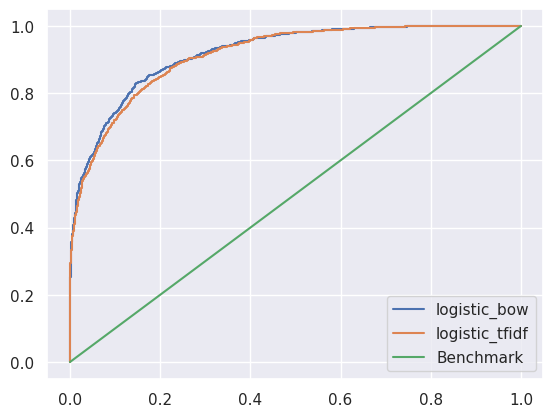

In [ ]:
sns.set()

# Plot ROC curves for each model in roc_dict
for k, v in roc_dict.items():
  plt.plot(v['FPR'], v['TPR'], label=k)

plt.plot(v['FPR'], v['FPR'], label='Benchmark')
plt.legend()
plt.show()

### NN model

#### Preparations for the model

This time let's use the Keras's tokenaizer:

In [ ]:
# Initialize Tokenizer with lower=False to preserve case
token = Tokenizer(lower=False)

# Fit Tokenizer on the training data x_train
token.fit_on_texts(x_train)

To address our task and ensure our model can classify correctly, we must convert each dialogue into a sequence of tokenized words. This specific tokenizer preserves the semantic meaning by using word embeddings, unlike BOW and TFIDF.

In [ ]:
def text_to_sequence(df):
  '''
  input: df (input DataFrame containing text data)
  output: df_dl (DataFrame with text converted to sequences)
  '''
  # Use the pre-fitted Tokenizer to convert text to sequences
  df_dl = token.texts_to_sequences(df)
  return df_dl

In [ ]:
# Convert training data, validation data and test data to sequences
x_train_dl = text_to_sequence(x_train)
x_val_dl = text_to_sequence(x_val)
x_test_dl = text_to_sequence(x_test)

Let's see how a dialogue looks now:

In [ ]:
x_train_dl[0]

[63, 129, 3, 1815, 34, 37]

After preprocessing the dialogues and without referring to the label, we wanted to take a look at **the length of the dialogues, calculating the minimum, maximum, and average length.**<br>
We need to ensure that all the dialogues have the same length, and plotting these results can help us decide which value to choose:

In [ ]:
# Calculate the length of each document in x_train_dl
doc_len_list = [len(doc) for doc in x_train_dl]

# Calculate the maximum length, minimum length and average length of documents
max(doc_len_list), min(doc_len_list), np.mean(doc_len_list)

(197, 0, 6.426975559898868)

<Axes: ylabel='Count'>

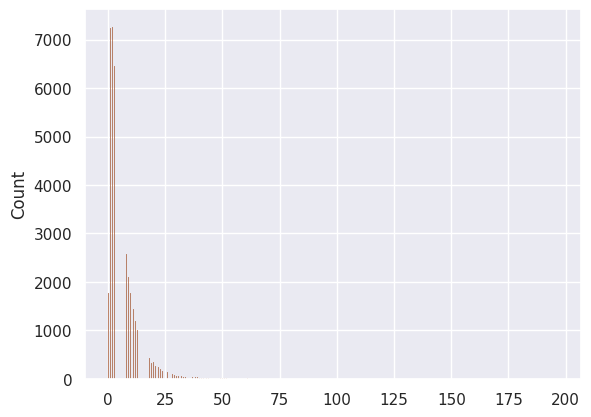

In [ ]:
# Plot a histogram of the documents lengths
sns.histplot(doc_len_list, color='sienna')

According to the distribution, we decided to use the value of $100$ words. We saw in the previous parts that there are a lot of common daily usage words in the dialogues, and perhaps some unique words or patterns are hidden in long dialogues. We tried setting `max_words` to $50$ and $75$, but it negatively affected our results on the test set.

Let's see how a sample looks like before and after applying the change:

In [ ]:
x_train_dl[10]

[2940, 7, 508, 383, 276, 69, 561]

In [ ]:
max_words = 100

# Pad sequences in training data, validation data and test data to max_words
x_train_dl = sequence.pad_sequences(x_train_dl, maxlen=max_words)
x_val_dl = sequence.pad_sequences(x_val_dl, maxlen=max_words)
x_test_dl = sequence.pad_sequences(x_test_dl, maxlen=max_words)

In [ ]:
x_train_dl[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 2940,    7,  508,  383,  276,   69,
        561], dtype=int32)

In [ ]:
total_words = len(token.word_index) + 1
total_words

20197

#### Building the architecture

Let's build the architecture of our model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=max_words)) # Used for proccesing sequences of words in NLP
model.add(Conv1D(128, 3, padding='same', activation='relu')) # Performs 1D convolution across the input sequence
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=4, return_sequences=True, kernel_regularizer=l1(0.001)))  # return_sequences=True for stacking RNN layers
model.add(Flatten()) # Flattens the input, which is necessary before passing it to a dense layer
model.add(Dense(64, activation='relu')) # Fully connected layer
model.add(Dropout(0.5)) # Regularization layer that randomly sets a fraction of input units to zero during training to prevent overfitting
model.add(Dense(1, activation='sigmoid')) # Fully connected layer with sigmoid for binary classification tasks
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           646304    
                                                                 
 conv1d (Conv1D)             (None, 100, 128)          12416     
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 128)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 50, 4)             2128      
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                        

**We explored various configurations of NN layers and their parameters:**<br>

1. We tried both `MaxPooling1D` and `AveragePooling1D` layers, but the first yielded better results.
2. The addition of the `LSTM` layer positively affected the results.<br>
We experimented with different values for both `MaxPooling1D`  and `LSTM` parameters.
3. For the LSTM layer, we applied `kernel_regularization`. We tested 3 values: $[0.01, 0.001, 0.0001]$.<br>
The best performing value for our model was $0.01$.<br>
(Reminder for us: When the regularization parameter is smaller (closer to zero) the penalty on the weights is weaker, meaning the model is less regularized).<br>
We also experimented with L2 regularization, but found that L1 regularization was better.
4. We attempted to add a `BatchNormalization` layer, but it negatively affected the results.
5. We also experimented with different values for the `Dropout` regularization layer, testing this list of values: $[0.3, 0.5, 0.6]$.<br> The best performing value for our model was $0.5$.

In [ ]:
model.fit(x_train_dl, y_train, validation_data=(x_val_dl, y_val), epochs=5, batch_size=64)

Epoch 1/5
872/872 [==============================] - 42s 40ms/step - loss: 0.5195 - accuracy: 0.7263 - val_loss: 0.4508 - val_accuracy: 0.7613
Epoch 2/5
872/872 [==============================] - 12s 13ms/step - loss: 0.3816 - accuracy: 0.8090 - val_loss: 0.4427 - val_accuracy: 0.7678
Epoch 3/5
872/872 [==============================] - 8s 9ms/step - loss: 0.3326 - accuracy: 0.8347 - val_loss: 0.4783 - val_accuracy: 0.7655
Epoch 4/5
872/872 [==============================] - 10s 12ms/step - loss: 0.3014 - accuracy: 0.8484 - val_loss: 0.4855 - val_accuracy: 0.7668
Epoch 5/5
872/872 [==============================] - 8s 9ms/step - loss: 0.2776 - accuracy: 0.8599 - val_loss: 0.5397 - val_accuracy: 0.7577


Let's evaluate our model:

In [ ]:
model.evaluate(x_test_dl, y_test)

133/133 [==============================] - 1s 4ms/step - loss: 0.4491 - accuracy: 0.8622


[0.4491192102432251, 0.8621907830238342]

We will save variables so that we can use them when generating a CSV file in the end of this assignment:

In [ ]:
NN_test_score = model.evaluate(x_test_dl, y_test)[1]
NN_train_score = model.evaluate(x_train_dl, y_train)[1]
total_trainable_params = model.count_params()
num_layers = len(model.layers)
embedding_dim = model.layers[0].output_dim

1743/1743 [==============================] - 7s 4ms/step - loss: 0.2425 - accuracy: 0.8824


##**Exploring the results**

### Accuracy comparison between the models




In [ ]:
# adding the NN accuracy to the scores dictionary
scores_dict['neural_network'] = {'Accuracy': NN_test_score}

# usig only the values of the accuracy key
accuracy_values = {model: scores['Accuracy'] for model, scores in scores_dict.items()}

# creating a DataFrame from the accuracy values
scores_df = pd.DataFrame.from_dict(accuracy_values, orient='index', columns=['Accuracy'])

In [ ]:
scores_df

,Accuracy
logistic_bow,0.838163
logistic_tfidf,0.829918
neural_network,0.862191


The comparison between model accuracies indicates that while there is not a significant difference between the logistic regression models and the neural network, the neural network model demonstrates a slight improvement in performance. This suggests that while all models perform relatively close to each other, the deep learning approach offers a modest enhancement in accuracy. This improvement underscores the effectiveness of leveraging deep learning techniques for dialogue classification tasks, potentially due to its capacity to capture intricate patterns within the data.

###Accuracy of long texts VS. Accuracy of short texts

Let's conduct a comparative analysis between short and long dialogues (above 50 words) to ascertain any disparities in classification accuracy.

In [ ]:
# Function to categorize dialogues into short and long based on length
def categorize_dialogues(df, threshold=50):
    df['Dialogue_length'] = df['Dialogue_length'].astype(int)
    short_dialogues = df[df['Dialogue_length'] <= threshold]
    long_dialogues = df[df['Dialogue_length'] > threshold]
    return short_dialogues, long_dialogues


In [ ]:
# Categorize dialogues into short and long
short_dialogues, long_dialogues = categorize_dialogues(df)

# Evaluate model performance on short dialogues
x_short = text_to_sequence(short_dialogues['Dialogue'])
x_short = sequence.pad_sequences(x_short, maxlen=max_words)
y_short = lb.transform(short_dialogues['Show'])
accuracy_short = model.evaluate(x_short, y_short, verbose=0)[1] * 100

# Evaluate model performance on long dialogues
x_long = text_to_sequence(long_dialogues['Dialogue'])
x_long = sequence.pad_sequences(x_long, maxlen=max_words)
y_long = lb.transform(long_dialogues['Show'])
accuracy_long = model.evaluate(x_long, y_long, verbose=0)[1] * 100

# Print accuracy for short and long dialogues
print(f'Accuracy on Short Dialogues: {accuracy_short:.2f}%')
print(f'Accuracy on Long Dialogues: {accuracy_long:.2f}%')

Accuracy on Short Dialogues: 85.58%
Accuracy on Long Dialogues: 97.76%


We observed that the model performs reasonably well on short dialogues, achieving accuracy close to its reported score. Interestingly, when evaluating longer dialogues (exceeding 50 words), the model's accuracy substantially improves, almost reaching 100%. This suggests that the model might be more adept at classifying longer dialogues due to factors such as text complexity, training data bias, overfitting, or better feature extraction capabilities. These findings provide valuable insights into the behavior and performance of the model, indicating its proficiency in handling different lengths of text inputs.

###WordCloud plot for most frequent words



We employed WordCloud visualizations to unveil the most prevalent words within each series, providing insight into the distinctive linguistic characteristics of the series.

In [ ]:
def generate_wordcloud(df, show):
    '''
    input: df (DataFrame containing dialogue and show information),
           show (Seinfeld or Friends)
    output: plot
    '''
    # Concatenate dialogue text for the specified show
    text = ' '.join(df[df['Show'] == show]['Dialogue'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(text)

    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {show} Dialogues')
    plt.axis('off')
    plt.show()

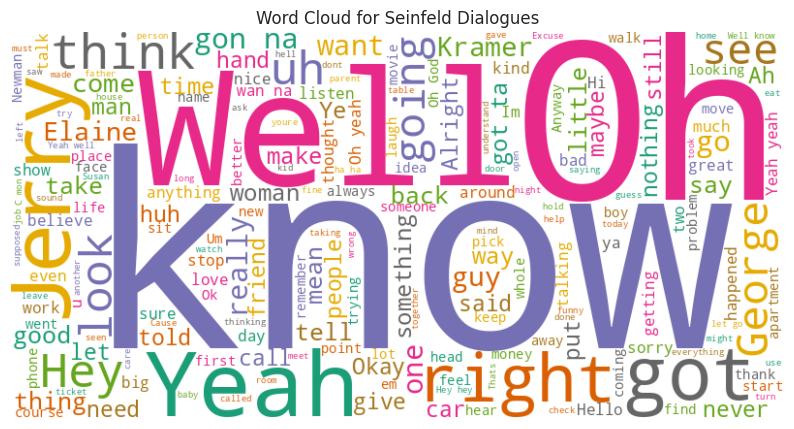

In [ ]:
generate_wordcloud(df, 'Seinfeld')

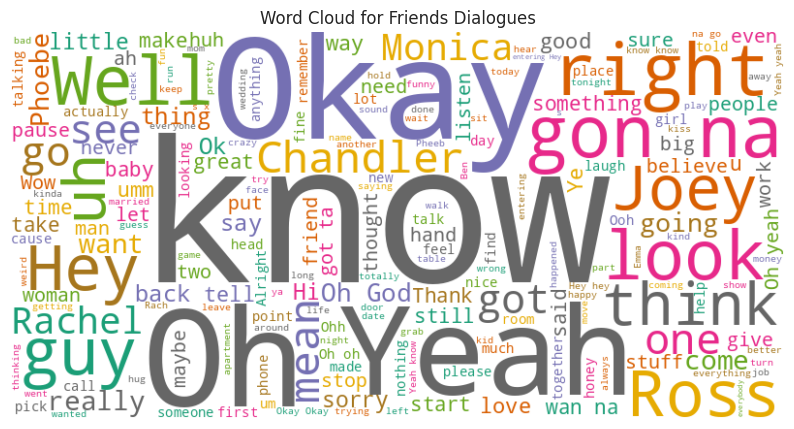

In [ ]:
generate_wordcloud(df, 'Friends')

The prominence of everyday life themes and character names in the WordClouds of both "Friends" and "Seinfeld" is unsurprising, given the sitcom genre's focus on relatable human experiences and character-driven narratives. For example the word 'know' is very popular word in everyday life and in both series. This observation underscores the genre's emphasis on depicting familiar scenarios and memorable characters, contributing to the enduring appeal of these shows among audiences.

###Confusion matrix

In [ ]:
def plot_confusion_matrix(model, x_test, y_test):
    '''
    input: model (trained binary classification model),
           x_test (test data),
           y_test (test label)
    output: plot
    '''
    # Predictions
    y_pred = model.predict(x_test)

    # Convert predictions to binary labels
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)

    # Define custom colormap using color names
    cmap_colors = ['lightgray', 'cadetblue', 'cadetblue', 'darksalmon']
    cmap = LinearSegmentedColormap.from_list('Custom', cmap_colors, len(cmap_colors))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=['Seinfeld', 'Friends'], yticklabels=['Seinfeld', 'Friends'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

133/133 [==============================] - 1s 3ms/step


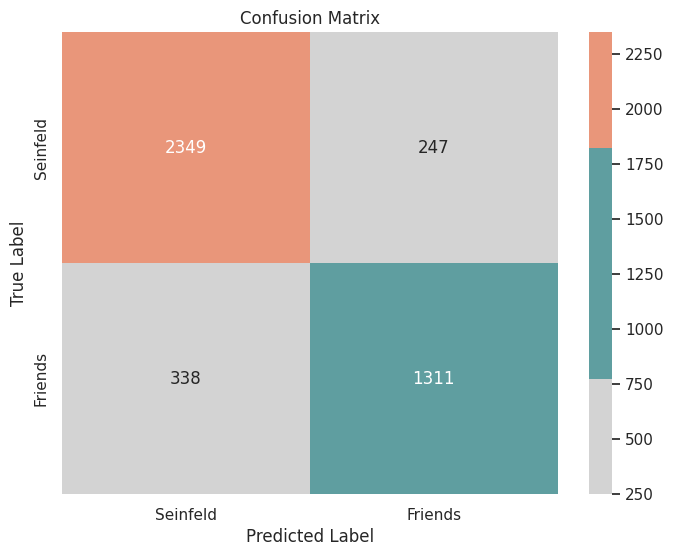

In [ ]:
# Generate confusion matrix for the test set
plot_confusion_matrix(model, x_test_dl, y_test)

This graph allows visualization of the performance of our model by showing the number of correct and incorrect predictions, as well as the types of errors made.It can be seen that the relative percentage of errors is low compared to the percentage of correct predictions.

### Error analysis

In [ ]:
# Make predictions on the test set
predictions = model.predict(x_test_dl)

# Convert predicted probabilities to class labels
predicted_labels = (predictions > 0.5).astype(int)  # Thresholding at 0.5 to convert probabilities to binary labels

# Convert true labels back to original labels
true_labels = lb.inverse_transform(y_test)

# Identify misclassified indices
misclassified_indices = np.where(predicted_labels.flatten() != y_test.flatten())[0]

# Shuffle the misclassified indices
random.shuffle(misclassified_indices)

# Print a random selection of 10 misclassified dialogues
print("Randomly 10 Selected Misclassified Dialogues:")
for idx, index in enumerate(misclassified_indices[:10], 1):
    print(f"Dialogue {idx}:")
    print("Dialogue:", x_test.iloc[index])
    if predicted_labels[index] == 0:
        predicted_show = 'Friends'
    else:
        predicted_show = 'Seinfeld'
    true_show = true_labels[index]
    print("Predicted Label:", predicted_show)
    print("True Label:", true_show)
    print()

133/133 [==============================] - 0s 3ms/step
Randomly 10 Selected Misclassified Dialogues:
Dialogue 1:
Dialogue: Well , well married . Even though ' spoken wife since wedding .
Predicted Label: Seinfeld
True Label: Friends

Dialogue 2:
Dialogue: point . wedding one week . got ( Holds invitation ) today .
Predicted Label: Friends
True Label: Seinfeld

Dialogue 3:
Dialogue: Ok ! ( take camera walk backwards take shot ) See ? Scared swing , bet feel pretty silly ( swinging boy knock ) Ow !
Predicted Label: Seinfeld
True Label: Friends

Dialogue 4:
Dialogue: ? crazy love ' take anymore ? .. ?
Predicted Label: Friends
True Label: Seinfeld

Dialogue 5:
Dialogue: Ah , ' ex-roommate , moved four year ago , I-I ' sub-letting apartment .
Predicted Label: Friends
True Label: Seinfeld

Dialogue 6:
Dialogue: ... street kid ride bike maybe ice-cream truck go .
Predicted Label: Seinfeld
True Label: Friends

Dialogue 7:
Dialogue: ' anything . easier two u , like college , remember ? ... brea

By studying our errors and specify them, we can gain insights into the model's weaknesses and make targeted improvements to enhance its accuracy and effectiveness, which at the end, will lead to more reliable AI system.






### Misclassified words

In this section, we investigate the 10 most misclassified words in the "Friends" and "Seinfeld" classes based on the performance of our trained model.<br>
As explained in the preprocessing part, we decided not to remove non-alphanumeric characters, so in this section we ignored them to get information for the most common words:

In [ ]:
def plot_missclassified_words(missclassified_words_list, color, show):
  '''
  input: missclassified_words_list (List of tuples containing words
                                    and their frequencies),
         color (the color to use in the plot),
         show (Seinfeld or Friends)
  output: plot
  '''

  # Extract words and frequencies
  words, frequencies = zip(*missclassified_words_list)

  # Create bar plot
  plt.figure(figsize=(10, 6))
  bars = plt.bar(words, frequencies, color=color)

  # Add labels and title
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  if show == 'Friends':
    plt.title('Words Misclassified as Friends')
  else:
    plt.title('Words Misclassified as Seinfeld')

  # Rotate x-axis labels for better readability if needed
  plt.xticks(rotation=45)

  # Add frequency annotations on each bar
  for bar, frequency in zip(bars, frequencies):
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), frequency,
              ha='center', va='bottom')

  # Show plot
  plt.tight_layout()
  plt.show()

In [ ]:
# Initialize counters for words/phrases misclassified as Friends and Seinfeld
misclassified_as_friends = Counter()
misclassified_as_seinfeld = Counter()

# Define regex pattern to match alphanumeric characters
pattern = re.compile(r'[^a-zA-Z0-9\s]')

for index in misclassified_indices:
    # Get the dialogue, predicted label, and true label
    dialogue = x_test.iloc[index]
    predicted_label = predicted_labels[index]
    true_label = true_labels[index]

    # Tokenize the dialogue
    words = dialogue.split()

    # Clean words using regex pattern and filter out empty strings
    words = [pattern.sub('', word) for word in words if word.strip()]

    # Update counters based on misclassifications
    if predicted_label == 0:  # Misclassified as Friends
        misclassified_as_friends.update(words)
    else:  # Misclassified as Seinfeld
        misclassified_as_seinfeld.update(words)

# Convert Counter object to a list of tuples (word, frequency)
misclassified_as_friends_list = misclassified_as_friends.most_common(10)[1:]
misclassified_as_seinfeld_list = misclassified_as_seinfeld.most_common(10)[1:]



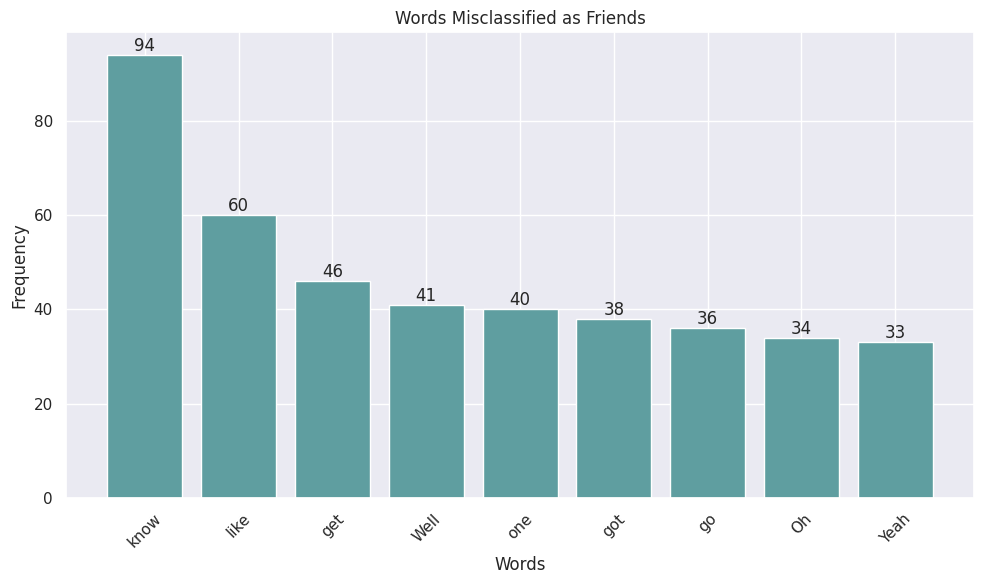

In [ ]:
plot_missclassified_words(misclassified_as_friends_list, 'cadetblue', 'Friends')

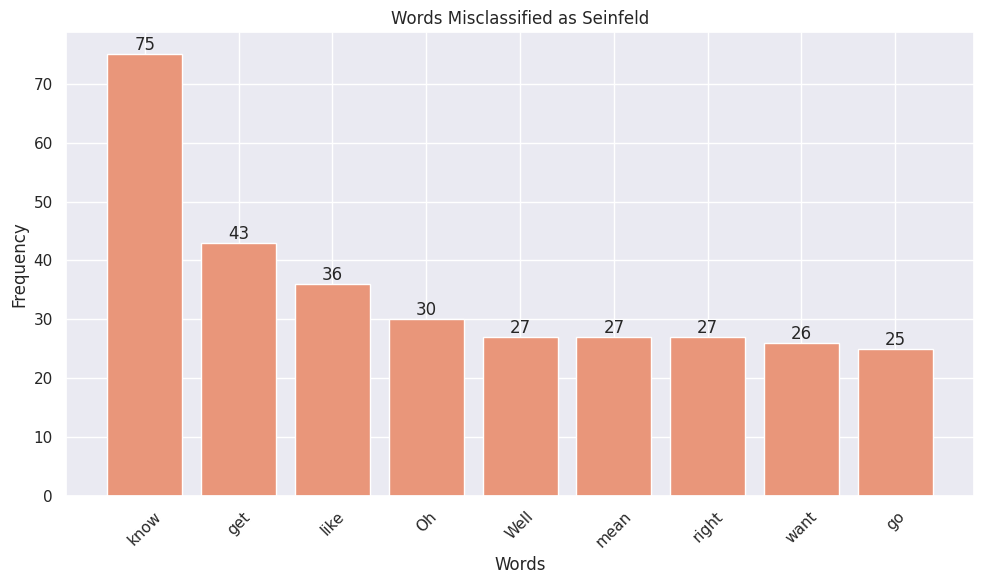

In [ ]:
plot_missclassified_words(misclassified_as_seinfeld_list, 'darksalmon', 'Seinfeld')

Based on the provided results, we can learn a few things:

*   `know`- This word was misclassified 59 times as Friends and 119 times as Seinfeld and it is the **most common misclassified word in both shows** If we fo back to the "WordCloud plot for most frequent words" section, we can see that this word is the **most frequent word in both shows**. From these two analyses, we can understand that it is a common word that appears in both shows so the model was probably confused in their association each time to the correct show.
*  `like`, `get`, `got`, `Well` - These words were also misclassified a relatively large number of times in both shows. Like in the word `know`, we can learn that these words are probably common in both shows.



###Model evaluate per actor

Let's evaluate the model's accuracy in classifying dialogues by individual actors:

In [ ]:
# Function to filter test set by character and evaluate accuracy
def evaluate_character_accuracy(model, token, test_df, character, lb, max_words):
    '''
    input: model (trained model to evaluate),
           token (tokenizer object for tokenization),
           test_df (test DataFrame containing dialogue and character labels),
           character (character to filter test set by),
           lb (LabelBinarizer object for label encoding),
           max_words (Maximum number of words for padding sequences)
    output: accuracy (accuracy of the model for the specified character)
    '''
    # Filter test set by character
    character_lines = test_df[test_df['Character'] == character]

    # Preprocess dialogue
    x_character_test, y_character_test = test_pipline(test_df, lb)

    # Tokenize and pad sequences
    token.fit_on_texts(x_character_test)
    X_character_dl = text_to_sequence(x_character_test)
    X_character_dl = sequence.pad_sequences(X_character_dl, maxlen=max_words)
    Y_character_dl = lb.transform(y_character_test)

    # Evaluate accuracy
    accuracy = model.evaluate(X_character_dl, Y_character_dl)[1]

    return accuracy

  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 1s 4ms/step - loss: 1.7118 - accuracy: 0.7058


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 0s 3ms/step - loss: 1.8738 - accuracy: 0.6994


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 0s 3ms/step - loss: 1.9621 - accuracy: 0.6867


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 0s 3ms/step - loss: 1.9719 - accuracy: 0.6829


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 0s 4ms/step - loss: 2.0593 - accuracy: 0.6787


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 0s 3ms/step - loss: 1.9404 - accuracy: 0.6978


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 0s 3ms/step - loss: 1.9154 - accuracy: 0.6935


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 0s 3ms/step - loss: 1.8886 - accuracy: 0.6966


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 0s 4ms/step - loss: 2.0043 - accuracy: 0.6834


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

133/133 [==============================] - 0s 4ms/step - loss: 1.9844 - accuracy: 0.6820


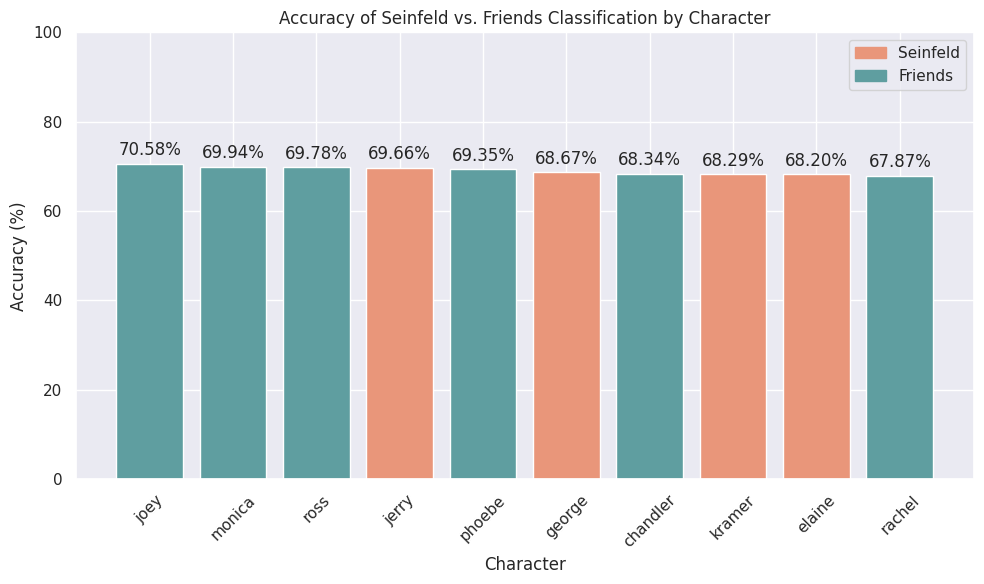

In [ ]:
# List of characters
characters = test['Character'].unique()

# Dictionary to store accuracy scores
character_accuracy = {}

# Map each character to its respective show (all lowercase)
character_show_map = {
    'jerry': 'seinfeld',
    'george': 'seinfeld',
    'elaine': 'seinfeld',
    'kramer': 'seinfeld',
    'rachel': 'friends',
    'ross': 'friends',
    'monica': 'friends',
    'chandler': 'friends',
    'joey': 'friends',
    'phoebe': 'friends'
}

# Define colors for Seinfeld and Friends characters
seinfeld_color = 'darksalmon'
friends_color = 'cadetblue'

# Evaluate accuracy for each character
for character in characters:
    accuracy = evaluate_character_accuracy(model, token, test, character, lb, max_words)
    character_accuracy[character] = accuracy * 100

# Sort characters by accuracy
sorted_characters = sorted(character_accuracy, key=character_accuracy.get, reverse=True)

# Visualize results
plt.figure(figsize=(10, 6))

# Assign colors based on the show
colors = [seinfeld_color if character_show_map[character.lower()] == 'seinfeld' else friends_color for character in sorted_characters]

bars = plt.bar(sorted_characters, [character_accuracy[char] for char in sorted_characters], color=colors)
plt.xlabel('Character')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Seinfeld vs. Friends Classification by Character')
plt.xticks(rotation=45)
plt.ylim(0, 100)

# Add text labels for accuracy percentages
for bar, accuracy in zip(bars, [character_accuracy[char] for char in sorted_characters]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{accuracy:.2f}%', ha='center', va='bottom')

# Add legend for series
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=seinfeld_color), plt.Rectangle((0,0),1,1, color=friends_color)],
           labels=['Seinfeld', 'Friends'])

plt.tight_layout()
plt.show()

The classification accuracy of the model shows a decline of approximately 15% when considering dialogue classification by specific characters. This decrease is understandable given that the model was trained solely on dialogue texts without explicit actor labels. For the model, discerning who said what is less critical; its primary objective is accurate classification of dialogues to their respective series. However, similarities in dialogue among characters may lead to misclassifications, where the dialogue is attributed to the correct series but not necessarily to the correct character.

### Generating a CSV file

In this section, we'll create a CSV file containing the following information:
*   Our test set accuracy
*   Our train set accuracy
*   Number of trainable parameters
*   Number of layers
*   Regularization methods
*   Number of epochs
*   Choice of loss function
*   Choice of optimizer
*   Embedding dimension



In [ ]:
results = {'Our test set accuracy': NN_test_score,
           'Our train set accuracy': NN_train_score,
           'Number of trainable parameters': total_trainable_params,
           'Number of layers': num_layers,
           'Regularization methods': ['l1 Kernel Regularizer, Dropout'],
           'Number of epochs': 5,
           'Choice of loss function': 'binary_crossentropy',
           'Choice of optimizer': 'adam',
           'Embedding dimension': embedding_dim
           }

df_results = pd.DataFrame(results)
df_results

,Our test set accuracy,Our train set accuracy,Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Choice of loss function,Choice of optimizer,Embedding dimension
0,0.862191,0.882372,673777,8,"l1 Kernel Regularizer, Dropout",5,binary_crossentropy,adam,32


In [ ]:
df_results.to_csv(os.path.join(os.getcwd(), 'exercise2.csv'))